<a href="https://colab.research.google.com/github/aswinaus/Observability/blob/main/Lyft10K_langsmith_observability_metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os

In [ ]:
!pip install pdfminer.six langsmith langchain langchain_openai chromadb pypdf nest_asyncio

In [ ]:
import nest_asyncio
nest_asyncio.apply()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from pdfminer.high_level import extract_text

def extract_text_from_pdf(pdf_path):
    return extract_text(pdf_path)

In [ ]:
# Download Data
data_dir = '/content/drive/MyDrive' # Input a data dir path from your mounted Google Drive

In [ ]:
# step 1: upload a PDF to the root of the file browser
# then change the variable below to be the name of your file
file_name = 'uber_10k_2023'

In [ ]:
pdf_text = extract_text_from_pdf(f"{data_dir}/RAG/data/10k/uber_10k_2023.pdf")

In [ ]:
pdf_text.split('\n')[0:10000]

In [ ]:
! pip install langchain-community


In [ ]:
!pip install chromadb openai

In [ ]:
import chromadb
from langchain.embeddings import OpenAIEmbeddings

In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import PyPDFLoader

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=300,
    chunk_overlap=50
)
loader = PyPDFLoader(f"{data_dir}/RAG/data/10k/uber_10k_2023.pdf")
# load_and_split uses RecursiveCharacterTextSplitter by default, but here I customize the chunk size & overlap
pages = loader.load_and_split(text_splitter)

In [ ]:
from google.colab import userdata
os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')

In [ ]:
# create vector store with Chroma
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import Chroma
from langchain_community.vectorstores.utils import filter_complex_metadata # import filter_complex_metadata

openai_api_key = os.environ["OPENAI_API_KEY"]
# filtered_chunked_markdown = filter_complex_metadata(chunked_markdown)

#index = Chroma.from_documents(documents=pages, embedding=OpenAIEmbeddings(openai_api_key=os.environ["OPENAI_API_KEY"]))

vectordb = Chroma.from_documents(documents=pages, embedding=OpenAIEmbeddings(openai_api_key=os.environ["OPENAI_API_KEY"]),persist_directory=f"{data_dir}/RAG/VectorDB/chroma_db_RAG_FOR_Evals")
vectordb.persist()
retriever = vectordb.as_retriever()

In [ ]:
# multi-query
from langchain.prompts import ChatPromptTemplate

template = """You are an AI language model Accounting assistant. Your task is to generate five
different versions of the given user question to retrieve relevant documents from a vector
database. By generating multiple perspectives on the user question, your goal is to help
the user overcome some of the limitations of the distance-based similarity search.
Provide these alternative questions separated by newlines. Original question: {question}"""
prompt_perspectives = ChatPromptTemplate.from_template(template)

from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI

generate_queries = (
    prompt_perspectives
    | ChatOpenAI(temperature=0, openai_api_key=openai_api_key)
    | StrOutputParser()
    | (lambda x: x.split("\n"))
)

In [ ]:
questiononRevenue = "Please summarize Financial and Operational Highlights for Uber?"

In [ ]:
generate_queries.invoke(questiononRevenue)

In [ ]:
question = "Could you give me a concise overview of the Business strategies employed by Uber?"

In [ ]:
generate_queries.invoke(question)

In [ ]:
# Retrieve docs given a list of queries
from langchain.retrievers.multi_query import MultiQueryRetriever
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(temperature=0, openai_api_key=openai_api_key)

#retriever = MultiQueryRetriever.from_llm(
#    retriever=index.as_retriever(), llm=llm
#)

**This section of the code focuses on refining the search results obtained from the vector database. It aims to improve the quality of the results by reranking the documents based on a scoring system.**

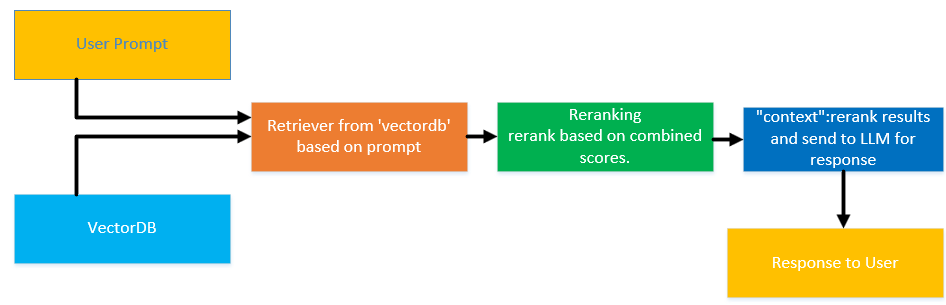

In [ ]:
# Rank documents
from langchain.load import dumps, loads

def rank_documents(results: list[list], k=60):
    fused_scores = {}

    for docs in results:
        for rank, doc in enumerate(docs):
            doc_str = dumps(doc)
            if doc_str not in fused_scores:
                fused_scores[doc_str] = 0
            previous_score = fused_scores[doc_str]
            fused_scores[doc_str] += 1 / (rank + k)

    reranked_results = [
        (loads(doc), score)
        for doc, score in sorted(fused_scores.items(), key=lambda x: x[1], reverse=True)
    ]

    return reranked_results

retrieval_chain = generate_queries | retriever.map() | rank_documents
docs = retrieval_chain.invoke(questiononRevenue)

In [ ]:
docs

In [ ]:
#Creating a RAG Pipeline
from operator import itemgetter
from langchain_core.runnables import RunnablePassthrough


# RAG
template = """Answer the following question based on this context:

{context}

Question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)


llm = ChatOpenAI(temperature=0, openai_api_key=openai_api_key)

# Chain
final_rag_chain = (
    {"context": retrieval_chain, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

final_rag_chain.invoke({"question":question})

In [ ]:
os.environ["LANGSMITH_TRACING"]="true"
os.environ["LANGSMITH_ENDPOINT"]="https://api.smith.langchain.com"
os.environ["LANGSMITH_API_KEY"]=userdata.get('LANGCHAIN_API_KEY')
os.environ["LANGSMITH_PROJECT"]="rag_observability"
os.environ["OPENAI_API_KEY"]=userdata.get('OPENAI_API_KEY')

In [ ]:
import os
print(f"LANGSMITH_TRACING: {os.environ.get('LANGSMITH_TRACING')}")
print(f"LANGSMITH_ENDPOINT: {os.environ.get('LANGSMITH_ENDPOINT')}")
print(f"LANGSMITH_API_KEY: {os.environ.get('LANGSMITH_API_KEY')}")
print(f"LANGSMITH_PROJECT: {os.environ.get('LANGSMITH_PROJECT')}")

In [ ]:
LANGSMITH_TRACING=True
LANGSMITH_ENDPOINT="https://api.smith.langchain.com"
LANGSMITH_API_KEY=userdata.get('LANGCHAIN_API_KEY')
LANGSMITH_PROJECT="rag_observability"
OPENAI_API_KEY=userdata.get('OPENAI_API_KEY')

In [ ]:
from langsmith import Client, traceable
import openai
from langchain.llms import OpenAI


client = Client(api_key=LANGSMITH_API_KEY)

#client = Client() # replace with your api key if you don't have environment variables set

#@traceable(run_type="chain")  # or client=client, if you don't have environment variables set
@traceable(run_type="chain", client=client, tracing_level="verbose")
def run_llm(prompt: str):
    llm = OpenAI()  # or any other llm you want to test with
    return llm(prompt)

run_llm("what is the meaning of life in the context of an IT Engineer and how will that change in the AI world in future?")

In [ ]:
import openai
from langsmith.wrappers import wrap_openai
from langsmith import traceable
from langchain.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI
from langchain.retrievers.multi_query import MultiQueryRetriever
from langchain.load import dumps, loads
from operator import itemgetter
from langchain_core.runnables import RunnablePassthrough

# Auto-trace LLM calls in-context
#client = wrap_openai(openai.Client())
client = Client(api_key=LANGSMITH_API_KEY)
@traceable # Auto-trace this function
def pipeline(user_input: str):
    # --- final_rag_chain logic starts here ---

    # generate_queries from final_rag_chain
    template = """You are an AI language model Accounting assistant. Your task is to generate five
    different versions of the given user question to retrieve relevant documents from a vector
    database. By generating multiple perspectives on the user question, your goal is to help
    the user overcome some of the limitations of the distance-based similarity search.
    Provide these alternative questions separated by newlines. Original question: {question}"""
    prompt_perspectives = ChatPromptTemplate.from_template(template)

    openai_api_key = os.environ["OPENAI_API_KEY"]  # Assuming you have OPENAI_API_KEY set

    generate_queries = (
        prompt_perspectives
        | ChatOpenAI(temperature=0, openai_api_key=openai_api_key)
        | StrOutputParser()
        | (lambda x: x.split("\n"))
    )

    # retriever from final_rag_chain (assuming you have 'vectordb' defined)
    retriever = vectordb.as_retriever()

    # rank_documents from final_rag_chain
    def rank_documents(results: list[list], k=60):
        fused_scores = {}
        for docs in results:
            for rank, doc in enumerate(docs):
                doc_str = dumps(doc)
                if doc_str not in fused_scores:
                    fused_scores[doc_str] = 0
                previous_score = fused_scores[doc_str]
                fused_scores[doc_str] += 1 / (rank + k)

        reranked_results = [
            (loads(doc), score)
            for doc, score in sorted(fused_scores.items(), key=lambda x: x[1], reverse=True)
        ]
        return reranked_results

    retrieval_chain = generate_queries | retriever.map() | rank_documents

    # RAG prompt from final_rag_chain
    template = """Answer the following question based on this context:

    {context}

    Question: {question}
    """
    prompt = ChatPromptTemplate.from_template(template)

    llm = ChatOpenAI(temperature=0, openai_api_key=openai_api_key)

    # final_rag_chain assembled
    final_rag_chain = (
        {"context": retrieval_chain, "question": RunnablePassthrough()}
        | prompt
        | llm
        | StrOutputParser()
    )

    # --- final_rag_chain logic ends here ---

    # Invoke final_rag_chain with user_input
    response = final_rag_chain.invoke({"question": user_input})

    # Log the response and potentially other metadata
    # ... (your logging logic) ...

    return response

pipeline("What are the key business strategies utilized by Uber?")

In [ ]:
dataset_name = "Uber_10K_2023_v9"

In [ ]:
# create dataset
from langsmith import Client
import os

dataset_inputs = [
    '1. What are the key business strategies utilized by Uber?',
 '2. Can you provide a summary of Ubers business strategies?',
 '3. How does Uber approach its business strategies?',
 '4. What are the main tactics Uber uses to drive its business success?',
 '5. Could you outline the strategic approaches taken by Uber in its operations?'
]

dataset_outputs = [
    {"should_contain": ["ee the section titled “Reconciliations of Non-GAAP Financial Measures", "“Certain Key Metrics and Non-GAAP Financial Measures” below for more information", "MAPCs presented for annual periods are MAPCs for the fourth quarter of the year."]},
    {"should_contain": ["the following discussion contains forward-looking statements that reflect our plans, estimates,and beliefs. Our actual results could differ materially from those discussed in the forward-looking statements.", '“Risk Factors”, for a discussion of factors thatcould cause actual results to differ materially from the results described in or implied by the forward-looking statements contained in the following discussion andanalysis']},
    {"should_contain": ["massive network, leading technology, operational excellence, and product expertise to power movement from point Ato point B. We develop and operate proprietary technology applications supporting a variety of offerings on our platform. We connect consumers with providers ofride services, merchants as well as delivery service providers for meal preparation, grocery and other delivery services."]},
    {"should_contain": ["Revenue $ 31,877 $ 37,281 17 % 18 %\nIncome (loss) from operations $ (1,832) $ 1,110 **\nNet income (loss) attributable to Uber Technologies, Inc. $ (9,141) $ 1,887"]}, # reading from a table
    {"should_contain": ["EBITDA $ 1,713 $ 4,052 137 %\nNet cash provided by operating activities $ 642 $ 3,585 **\nFree cash flow $ 390 $ 3,362 **\n See the section titled “Reconciliations of Non-GAAP Financial Measures” for more information and reconciliations to the most directly comparable GAAPfinancial measure.\n See the section titled “Certain Key Metrics and Non-GAAP Financial Measures” below for more information.\n MAPCs presented for annual periods are MAPCs for the fourth quarter of the year."]}, # reading from a table
]

# ensure you have this set up
from google.colab import userdata
os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGCHAIN_API_KEY')
langchain_api_key = os.environ["LANGCHAIN_API_KEY"]

client = Client(api_key=langchain_api_key)

dataset = client.create_dataset(
    dataset_name=dataset_name,
    description="Uber 10K 2023 questions",
)
client.create_examples(
    inputs=[{"question": q} for q in dataset_inputs],
    outputs=dataset_outputs,
    dataset_id=dataset.id,
)

In [ ]:
import time
 #run evals in langsmith
from langsmith.schemas import Run, Example

from langsmith.evaluation import evaluate, LangChainStringEvaluator

def should_contain(run: Run, example: Example) -> dict:
    prediction = run.outputs.get("output") or ""
    required = example.outputs.get("should_contain") or []
    score = any(phrase in prediction for phrase in required)
    return {"key":"should_contain", "score": score}

rag_observability = [
  should_contain,
]
runner = final_rag_chain
def query_wrapper(query_dict):
       start_time = time.time()
       query_string = query_dict['question']
       response = runner.invoke(query_string)
       end_time = time.time()
       execution_time = end_time - start_time
       return {"output": response, "execution_time": execution_time}

experiment_results = evaluate(
    query_wrapper,
    data=dataset_name,
    evaluators=rag_observability,
    experiment_prefix="uber10Kv2",
    client=client,
)

In [ ]:
!pip install --upgrade langchain langsmith

In [ ]:
from langsmith.evaluation import (
       evaluate,
       LangChainStringEvaluator,
       PairwiseStringEvaluator,
       RegexEvaluator
   )
def should_contain(run: Run, example: Example) -> dict:
       prediction = run.outputs.get("output") or ""
       required = example.outputs.get("should_contain") or []
       score = any(phrase in prediction for phrase in required)
       return {"key": "should_contain", "score": score}
def similarity_to_ground_truth(run: Run, example: Example) -> dict:
       prediction = run.outputs.get("output") or ""
       ground_truth = example.outputs.get("output") or ""  # Ground truth
       evaluator = PairwiseStringEvaluator(similarity_metric="cosine")
       score = evaluator.compare_strings(prediction, ground_truth)
       return {"key": "similarity", "score": score}
def contains_regex_pattern(run: Run, example: Example) -> dict:
       prediction = run.outputs.get("output") or ""
       regex_pattern = example.outputs.get("regex_pattern") or ""  # Get regex pattern
       evaluator = RegexEvaluator(regex_pattern)
       score = evaluator.evaluate_string(prediction)
       return {"key": "regex_match", "score": score}
rag_observability = [
       should_contain,
       similarity_to_ground_truth,
       contains_regex_pattern,
]

In [ ]:
import time

def query_wrapper(query_dict):
       start_time = time.time()
       query_string = query_dict['question']
       response = runner.invoke(query_string)
       end_time = time.time()
       execution_time = end_time - start_time
       return {"output": response, "execution_time": execution_time}

   # ... (later in the evaluate call) ...
experiment_results = evaluate(
       query_wrapper,
       data=dataset_name,
       evaluators=rag_observability,
       experiment_prefix="uber10Kv4",
       client=client,
       # Add metadata to runs for tracking
       metadata={"data_source": dataset_name},
       tags=["RAG", "Uber_10K"],
   )

In [ ]:
!pip install -U langchain langchain-openai

In [ ]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI()
llm.invoke("Hello, world!")